# Mini Project 1

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

**Instructions** Use current stock data to create two potentially profitable investment portfolios. One that is higher risk and one that is lower risk.

-- You are to interpret and explain your interpretation of a high risk profile and low risk profile of a portfolio. You should provide some measurable quantitative data in your explanation.

In [22]:
# Importing required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime as dt
from scipy.optimize import minimize

# Plotting style
sns.set_style('darkgrid')

np.random.seed(1205)

## Define Tickers and Download Data

In [23]:
# Choose a diversified set of stocks from different industries
tickers = ['AAPL', 'TSLA', 'JNJ', 'NVDA', 'JPM', 'WMT', 'XOM', 'T']

# Define time period (last 2 years)
start_date = dt.datetime(2022, 1, 1)
end_date = dt.datetime(2024, 12, 31)

# Download stock data (close prices)
data = yf.download(tickers, start=start_date, end=end_date)['Close']

[*********************100%***********************]  8 of 8 completed


## Calculate Log Returns & Cumulative Returns

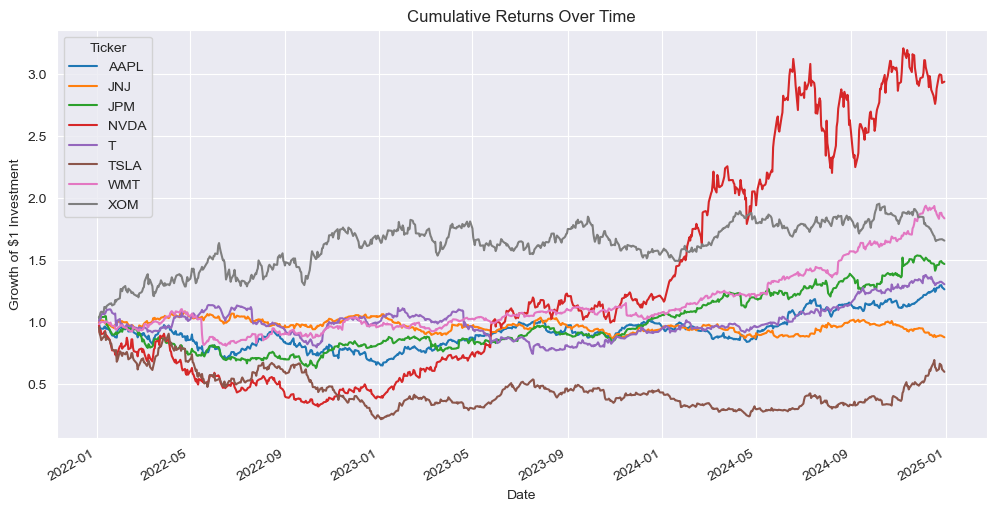

In [24]:
# Calculate daily log returns
returns = np.log(data / data.shift(1)).dropna()

# Compute cumulative returns for visualization
cumulative_returns = (1 + returns).cumprod()

# Plot cumulative returns
cumulative_returns.plot(figsize=(12, 6))
plt.title("Cumulative Returns Over Time")
plt.ylabel("Growth of $1 Investment")
plt.show()

## Analyze Volatility and Correlation

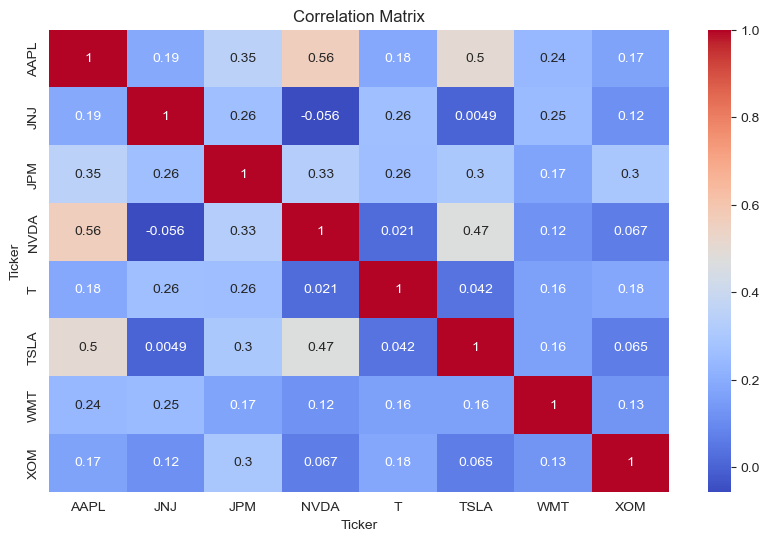

In [25]:
# Annualized standard deviation (volatility) of returns
annual_volatility = returns.std() * np.sqrt(252)

# Correlation matrix between assets
correlation_matrix = returns.corr()

# Plot heatmap of correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Sort and inspect volatilities
annual_volatility.sort_values(ascending=False)

# Annualized covariance matrix
cov_matrix = returns.cov() * 252

In [26]:
# Annualized covariance matrix
cov_matrix = returns.cov() * 252

def portfolio_volatility(weights, cov_matrix=cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def portfolio_return(weights, mean_returns):
    return np.dot(weights, mean_returns) * 252

def get_constraints(min_w=0.05, max_w=0.35):
    return (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'ineq', 'fun': lambda x: np.min(x) - min_w},
        {'type': 'ineq', 'fun': lambda x: max_w - np.max(x)}
    )

mean_daily_returns = returns.mean()

In [27]:
n_assets = len(tickers)
init_guess = np.array([1/n_assets] * n_assets)

constraints = get_constraints(min_w=0.05, max_w=0.35)

low_risk_result = minimize(portfolio_volatility, init_guess, constraints=constraints)
low_risk_weights = low_risk_result.x

# Show portfolio
print("Low-Risk Portfolio Weights:")
for t, w in zip(tickers, low_risk_weights):
    print(f"{t}: {w:.4f}")
print(f"Portfolio Volatility: {low_risk_result.fun:.4f}")

Low-Risk Portfolio Weights:
AAPL: 0.0500
TSLA: 0.3500
JNJ: 0.0500
NVDA: 0.0500
JPM: 0.1211
WMT: 0.0500
XOM: 0.2060
T: 0.1228
Portfolio Volatility: 0.1337


In [28]:
def neg_portfolio_volatility(weights, cov_matrix=cov_matrix):
    return -np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def neg_return(weights, mean_returns=mean_daily_returns):
    #return -np.dot(weights, mean_returns)
    return -np.dot(weights, mean_returns) * 252

In [29]:
# Relax max weight constraint to allow concentrated positions
constraints_risky = get_constraints(min_w=0.01, max_w=0.80)

high_risk_result = minimize(neg_portfolio_volatility, init_guess, constraints=constraints_risky)
high_risk_weights = high_risk_result.x

print("High-Risk Portfolio Weights:")
for t, w in zip(tickers, high_risk_weights):
    print(f"{t}: {w:.4f}")
print(f"Portfolio Volatility: {-high_risk_result.fun:.4f}")

High-Risk Portfolio Weights:
AAPL: 0.0100
TSLA: 0.0100
JNJ: 0.0100
NVDA: 0.4670
JPM: 0.0100
WMT: 0.4730
XOM: 0.0100
T: 0.0100
Portfolio Volatility: 0.4702


In [30]:
# Try maximizing expected return subject to less conservative bounds
constraints_return = get_constraints(min_w=0.01, max_w=0.8)

high_return_result = minimize(neg_return, init_guess, constraints=constraints_return)
high_return_weights = high_return_result.x
high_return = -high_return_result.fun
high_volatility = portfolio_volatility(high_return_weights)

print("High-Return Portfolio Weights:")
for t, w in zip(tickers, high_return_weights):
    print(f"{t}: {w:.4f}")
print(f"Portfolio Volatility: {high_volatility:.4f}")

High-Return Portfolio Weights:
AAPL: 0.0100
TSLA: 0.0100
JNJ: 0.0100
NVDA: 0.8000
JPM: 0.0137
WMT: 0.0100
XOM: 0.1352
T: 0.0111
Portfolio Volatility: 0.4473


In [31]:
low_risk_ret = portfolio_return(low_risk_weights, mean_daily_returns)
high_risk_ret = portfolio_return(high_risk_weights, mean_daily_returns)
high_return_ret = portfolio_return(high_return_weights, mean_daily_returns)

print(f"Low-Risk Return: {low_risk_ret:.4f}, Volatility: {low_risk_result.fun:.4f}")
print(f"High-Risk Return: {high_risk_ret:.4f}, Volatility: {-high_risk_result.fun:.4f}")
print(f"High-Return Return: {high_return_ret:.4f}, Volatility: {portfolio_volatility(high_return_weights):.4f}")

Low-Risk Return: 0.1156, Volatility: 0.1337
High-Risk Return: 0.2530, Volatility: 0.4702
High-Return Return: 0.4451, Volatility: 0.4473
